# Visualize

In [1]:
!pip3 install scikit-learn folium earthpy descartes

  Using cached https://files.pythonhosted.org/packages/2e/d0/860c4f6a7027e00acff373d9f5327f4ae3ed5872234b3cbdd7bcb52e5eff/scikit_learn-0.22-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/fd/a0/ccb3094026649cda4acd55bf2c3822bb8c277eb11446d13d384e5be35257/folium-0.10.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5b/26/105c13b51b383547d3f2d16aa562fc857dc2b1af4b93ddc52dd99f02ec13/earthpy-0.8.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/e5/b6/1ed2eb03989ae574584664985367ba70cd9cf8b32ee8cad0e8aaeac819f3/descartes-1.1.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/5c/cf6a2b65a321c4a209efcdf64c2689efae2cb62661f8f6f4bb28547cf1bf/joblib-0.14.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/63/36/1c93318e9653f4e414a2e0c3b98fc898b4970e939afeedeee6075dd3b703/branca-0.3.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/11/1d/42

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import *
import matplotlib.pyplot as plt
import folium
from folium import Circle, Polygon, PolyLine, Marker
import collections
from folium import plugins
from sklearn.neighbors import KDTree
import queue
import earthpy as et
import earthpy.clip as ec
from collections import defaultdict
from folium import plugins

In [2]:
from matplotlib import interactive
interactive(True)
%matplotlib inline

In [4]:
# dir = 'data/shapefiles/as_riv_15s/as_riv_15s.shp'
# asriv = gpd.read_file(dir)
# print(len(asriv))
# mekong_basin = gpd.read_file('data/shapefiles/mekong_basin.geojson')
# poly = mekong_basin.geometry.unary_union
# rivers_gpd = asriv[asriv.geometry.intersects(poly)]
rivers_gpd = gpd.read_file('mekong_rivers.shp')
# rivers_gpd.set_index('ARCID', inplace = True)
rivers_gpd

,UP_CELLS,geometry
0,435,"LINESTRING (94.62500 33.78958, 94.58125 33.789..."
1,572,"LINESTRING (94.58542 33.73542, 94.56458 33.735..."
2,321,"LINESTRING (94.66250 33.74375, 94.64792 33.743..."
3,102,"LINESTRING (94.50000 33.74167, 94.50625 33.735..."
4,1072,"LINESTRING (94.52708 33.73958, 94.52292 33.739..."
...,...,...
21542,3829263,"LINESTRING (105.99375 9.86042, 106.05208 9.802..."
21543,508,"LINESTRING (106.11458 9.78542, 106.11458 9.781..."
21544,3829922,"LINESTRING (106.08958 9.76042, 106.11458 9.735..."
21545,427,"LINESTRING (106.25000 9.77500, 106.24375 9.768..."


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.expand_frame_repr', True)
df = rivers_gpd.copy()

df['geometry'] = df.geometry.apply(lambda line: line.coords)
df['Count'] = df.geometry.apply(lambda line: len(line))
df.sort_values(by = 'Count', inplace = True)

In [7]:
dams_gpd = gpd.read_file('../data/shapefiles/dams/GRanD_Version_1_3/GRanD_dams_v1_3.shp')
dams_gpd = dams_gpd[dams_gpd.MAIN_BASIN == 'Mekong']

In [9]:
def add_line_string(line, strahler, m):
    attr = {'fill': '#007DEF', 'font-weight': 'bold', 'font-size': '24'}
    colorline_strah_map = ['blue', 'red', 'blue', 'yellow', 'black', 'orange']
    colordirection_strah_map = ['#0a7400', '#ac1a1a', '#0c37a6', '#bacc05', '#7e7f71', '#ec9900' ]
    
    riverline = folium.PolyLine(line, color = colorline_strah_map[strahler - 1], weight = 2.5).add_to(m)
    attr['fill'] = colordirection_strah_map[strahler - 1]
    plugins.PolyLineTextPath(riverline, '\u27a4     ', repeat=True, offet=6, attributes=attr).add_to(m)
    return m

def river_map(data):
    '''
    Visualize river map with dataframe from shapefile.
    Color of river based on its strahler number.
    '''
    center = [19.570263289179646, 102.519677]
    m = folium.Map(location=center, zoom_start=8, tiles='Stamen Terrain')
    hasStrahler = 'Strahler' in data.columns
    return m
    for _,row in data.iterrows():
        if not hasStrahler or row['Strahler'] > 0:
            lines = row['geometry']
            if lines.type == 'LineString':
                lines = MultiLineString([lines])
            for line in lines:
                rev_line = [[tuple(reversed(t)) for t in list(line.coords)]]
                if not hasStrahler:
                    color = 1
                else:
                    color = row['Strahler']
                m = add_line_string(rev_line, color, m)
    return m

def add_dams(dams, m):
    dams_feature = folium.FeatureGroup(name="Dams")
    for _, row in dams.iterrows():
        s = row.DAM_NAME + " " + str(row.geometry)
        dams_feature.add_child(Marker(location=[row.geometry.y, row.geometry.x], popup=s))

    dams_feature.add_to(m)
    return m

In [10]:
m = river_map(rivers_gpd)
m = add_dams(dams_gpd, m)

In [11]:
m.save('rivers_hydrosheds.html')

In [10]:
# ax = rivers_gpd[rivers_gpd.UP_CELLS > 500].plot(figsize=(20,20))
# dams_gpd.plot(markersize = 100, ax = ax, color='red')

# Graph

In [7]:
import networkx as nx 
import matplotlib.pyplot as plt
from shapely.ops import transform
from functools import partial
import pyproj

project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:32633'))

def get_coords(lines, linestring_number, coord_number):
    coords = lines[linestring_number]
    res = coords.coords[coord_number]
    return res[::-1]

"""
@job: calculate length of river in meters
@input: lines: multilinestring
@output: length in meter
"""
def river_length(lines):
    return 1
    total_len = 0
    for riv in lines:
        total_len += transform(project, riv).length
    return total_len

G = nx.DiGraph()
node_types = defaultdict(set)

for _, row in rivers_gpd[rivers_gpd.UP_CELLS > 0].iterrows():
    line = row['geometry']
    line = line.coords
#     print(len(line))
    for x, y in zip(line[:-1], line[1:]):
        G.add_node(x, attr = {'coord': x})
        G.add_node(y, attr = {'coord': y})
        G.add_edge(x, y) # , attr={'len': transform(project, LineString([x, y]))})
    node_types[line[0]] = node_types[line[0]] | set(['upstream'])
    node_types[line[-1]] = node_types[line[-1]] | set(['downstream'])
    
G.number_of_nodes(), G.number_of_edges()

/home/duongbao/Dropbox/code/HydroViet/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/duongbao/Dropbox/code/HydroViet/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


(143642, 143636)

In [8]:
N, K = G.order(), G.size()
avg_deg = float(K) / N
print("Nodes: ", N)
print("Edges: ", K)
print("Average degree: ", avg_deg)
print("SCC: ", nx.number_strongly_connected_components(G))
print("WCC: ", nx.number_weakly_connected_components(G))

Nodes:  143642
Edges:  143636
Average degree:  0.9999582294871974
SCC:  143642
WCC:  6


In [9]:
nodes = list(G.nodes)
coords = [G.nodes[node]['attr']['coord'] for node in nodes]
tree = KDTree(np.array(coords), leaf_size = 1)

## Add dams to node set

In [10]:
dams = []
for i, row in dams_gpd[dams_gpd.AREA_POLY > 0].iterrows():
    dams.append({'name': row['DAM_NAME'], 'coord': [row['LONG_DD'], row['LAT_DD']]})
for dam in dams:
    dam['type'] = 'dam'

## Add river watch stations to node set

In [19]:
river_watchs = [{'name': '242', 'coord': [102.555, 18.314]},
               {'name': '239', 'coord': [104.805, 17.324]},
               {'name': '84', 'coord': [104.715, 16.964]},
               {'name': '223', 'coord': [104.805, 12.104]},
               {'name': '34', 'coord': [105.255, 11.294]}]
for rw in river_watchs:
    rw['type'] = 'rw'

## Make externel node set

In [20]:
externel_nodes = dams + river_watchs
res = []
node_info = {'dam': {}, 'rw': {}}
new_externel_nodes = []

for e_node in externel_nodes:
    dist, node = map(lambda x: x[0][0], tree.query(np.array([e_node['coord']])))
    node = nodes[node]
    if dist <= 0.02:
        node_info[e_node['type']][node] = e_node
        node_types[node].add(e_node['type'])
        e = {}
        e.update(e_node)
        e.update({'node': node, 'dist': dist, 'name': e_node['name']})
        res.append(e)
        new_externel_nodes.append(e_node)
externel_nodes = new_externel_nodes
res.sort(key = lambda node: node['dist'])
# display(res)
selected_dams = dams_gpd[dams_gpd.DAM_NAME.isin([node['name'] for node in res if node['type'] == 'dam'])]
print(len(res))
# node_info

37


In [21]:
[enode for enode in externel_nodes if enode['type'] == 'rw']

[{'name': '242', 'coord': [102.555, 18.314], 'type': 'rw'},
 {'name': '239', 'coord': [104.805, 17.324], 'type': 'rw'},
 {'name': '223', 'coord': [104.805, 12.104], 'type': 'rw'},
 {'name': '34', 'coord': [105.255, 11.294], 'type': 'rw'}]

In [33]:
river_network = nx.DiGraph()
new_nodes = {}
old_nodes = {}
for node in G.nodes:
    if 'dam' in node_types[node] or 'rw' in node_types[node]: #len(node_types[node]) != 0:
        new_nodes[node] = len(new_nodes)
        old_nodes[new_nodes[node]] = node
        t = 'dam' if 'dam' in node_types[node] else 'rw'
        river_network.add_node(new_nodes[node], attr = {'coord': node,
                                                        'types': node_types[node],
                                                        'name': t + '_' + node_info[t][node]['name']
                                                       })

for node in river_network.nodes:
    old_node = old_nodes[node]
    len(old_node)
    dist = {old_node: 0}
    q = [old_node]
    for u in q:
        for v in G.neighbors(u):
#             if v not in dist:
#                 dist[v] = dist[u] + 1 # G.edges[u, v]['attr']['len']
                if 'dam' in node_types[v] or 'rw' in node_types[v]: #len(node_types[v]):
                    river_network.add_edge(node, new_nodes[v]) # , attr = dist[v])
                else:
                    q.append(v)

In [44]:
for node in river_network.nodes:
    node = river_network.nodes.get(node)['attr']
    node['types'] = list(node['types'])

In [45]:
print('Nodes:', river_network.number_of_nodes())
print('Edges;', river_network.number_of_edges())
print('Connected components:', nx.number_weakly_connected_components(river_network))

Nodes: 37
Edges; 36
Connected components: 1


In [46]:
[len(c) for c in nx.weakly_connected_components(river_network)]

[37]

In [51]:
def add_line_string2(line, m):
    attr = {'fill': '#007DEF', 'font-weight': 'bold', 'font-size': '160'}
    riverline = folium.PolyLine(line, color = 'blue', weight = 2.5).add_to(m)
    plugins.PolyLineTextPath(riverline, '\u27a4', center = True, attr = attr).add_to(m)
    return m

def river_map2(graph):
    '''
    Visualize river map with dataframe from shapefile.
    Color of river based on its strahler number.
    '''
    center = [19.570263289179646, 102.519677]
    m = folium.Map(location=center, zoom_start=9, tiles='Stamen Terrain')
    
    for x, y in graph.edges:
        line = [graph.nodes.get(x)['attr']['coord'][::-1], graph.nodes.get(y)['attr']['coord'][::-1]]
        m = add_line_string2(line, m)
        
    return m

color_types = {'dam': 'blue', 'rw': 'red', 'blue;river watch': 'orange'}
def add_externel_nodes(externel_nodes, m):
    dams_feature = folium.FeatureGroup(name="Dams")
    for e_node in externel_nodes:
        s = e_node['type'] + '_' + e_node['name']
        dams_feature.add_child(Marker(location = e_node['coord'][::-1], icon = folium.Icon(color = color_types[e_node['type']]), popup = s))
    dams_feature.add_to(m)
    return m
m = river_map2(river_network)
m = add_externel_nodes(externel_nodes, m)
m.save('pruned_rivers_network_hydrosheds.html')

(37, 36)

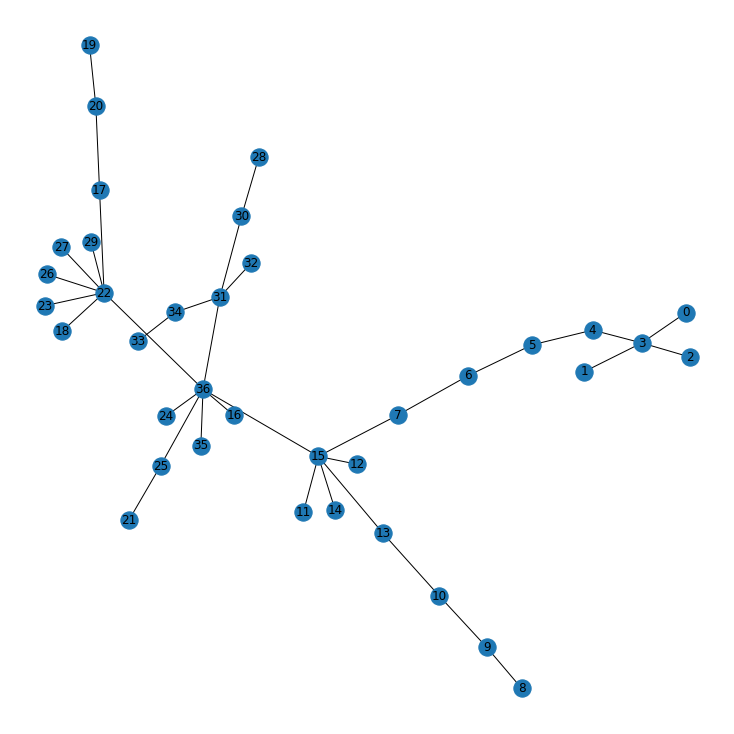

In [52]:
plt.figure(figsize = (10, 10))
nx.draw(river_network.to_undirected(), with_labels=True)
river_network.number_of_nodes(), river_network.number_of_edges()

In [49]:
from networkx.readwrite import json_graph
import json
data = json_graph.node_link_data(river_network.to_undirected())
json.dump(data, open('river_network.json', 'w'))

In [33]:
sources = [node for node in river_network.nodes if river_network.in_degree[node] == 0 and river_network.out_degree[node] > 0]

In [30]:
sinks = [node for node in river_network.nodes if river_network.in_degree[node] > 0 and river_network.out_degree[node] == 0]

In [ ]:
for node in sources:
    if river_network.nodes[node]['attr']['types'] != ['upstream']:
        print(river_network.nodes[node]['attr']['types'])

In [ ]:
for node in sinks:
    if river_network.nodes[node]['attr']['types'] != []:
        print(river_network.nodes[node]['attr']['types'])